# Install

In [1]:
%pip install -q -U kaggle_environments chex gymnax pygame termcolor numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


# Import

In [2]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

# Agents

Значения, которые должны выдавать агенты на каждом шаге игры
- 0 - rock
- 1 - paper
- 2 - scissors

## Простые агенты

### Rock Agent

In [3]:
%%writefile rock_agent.py

def rock_agent(observation, configuration) -> int:
    return 0

Overwriting rock_agent.py


### Paper Agent

In [4]:
%%writefile paper_agent.py

def paper_agent(observation, configuration) -> int:
    return 1

Overwriting paper_agent.py


### Scissors Agent

In [5]:
%%writefile scissors_agent.py

def scissors_agent(observation, configuration) -> int:
    return 2

Overwriting scissors_agent.py


## Копирование действия

### Copy Last Opponent Agent

Начиная со второго шага, возвращает ответ оппонента, сделанный на предыдущем шаге

In [6]:
%%writefile mirror_opponent_agent.py
import random

def mirror_opponent_agent(observation, configuration) -> int:
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randint(0, configuration.signs - 1)

Overwriting mirror_opponent_agent.py


### Copy Last Opponent Agent with Shift

Начиная со второго шага, возвращает ответ оппонента, сделанный на предыдущем шаге и сдвигает его на одну позицию
- rock -> paper
- paper -> scissors
- scissors -> rock


In [7]:
%%writefile mirror_shift_opponent_agent.py
import random

def mirror_shift_opponent_agent(observation, configuration) -> int:
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % 3
    else:
        return random.randint(0, configuration.signs - 1) 

Overwriting mirror_shift_opponent_agent.py


### Self Last Action and Shift

Начиная со второго шага, возвращает свой предыдущий ответ и сдвигает его на одну позицию
- rock -> paper
- paper -> scissors
- scissors -> rock

In [8]:
%%writefile mirror_shift_agent.py
import random

last_action = None

def mirror_shift_agent(observation, configuration) -> int:
    global last_action
    if observation.step == 0:
        action = random.randint(0, configuration.signs - 1)
    else:
        action = (last_action + 1) % 3
    last_action = action
    return action

Overwriting mirror_shift_agent.py


## Случайные действия

### Random Seed Angent

In [9]:
%%writefile random_seeded_agent.py
import random

def random_seeded_agent(observation, configuration, seed=42) -> int:
    if observation.step == 0:
        random.seed(seed)
    return random.randint(0, configuration.signs - 1)

Overwriting random_seeded_agent.py


### Random Unseeded Angent

In [10]:
%%writefile random_unseeded_agent.py
import random

def random_unseeded_agent(observation, configuration) -> int:
    return random.randint(0, configuration.signs - 1)

Overwriting random_unseeded_agent.py


## Реакции на результаты предыдущих ходов

### Reactionary

Если результат предыдущего хода проигрыш или ничья, то ответ сдвигается на позицию вперед

In [11]:
%%writefile reactionary.py
import random
from kaggle_environments.envs.rps.utils import get_score

last_react_action = None

def reactionary(observation, configuration) -> int:
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randint(0, configuration.signs - 1)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % 3

    return last_react_action

Overwriting reactionary.py


### Counter Reactionary

In [12]:
%%writefile counter_reactionary.py

import random
from kaggle_environments.envs.rps.utils import get_score

last_counter_action = None


def counter_reactionary(observation, configuration) -> int:
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randint(0, configuration.signs - 1)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % 3
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % 3

    return last_counter_action

Overwriting counter_reactionary.py


## Histogram

In [21]:
%%writefile histogram.py

import random
import numpy as np

action_history = []

def histogram_agent(observation, configuration) -> int:
    if observation.step == 0:
        return random.randint(0, configuration.signs - 1)
    else:
        action_history.append(observation.lastOpponentAction)
        counts = np.bincount([item for item in action_history], minlength=3)
        return (int(np.argmax(counts)) + 1) % 3


Overwriting histogram.py


## Statistical

In [22]:
%%writefile statistical.py

import random
import numpy as np


def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting statistical.py


# Competition

## Simple

In [15]:
from kaggle_environments import make

env = make("rps", configuration={"episodeSteps": 200})

env.reset()
env.run(["rock_agent.py", "scissors_agent.py"])
env.render(mode="ipython", width=500, height=450)

## Final

In [23]:
list_names = [
    "rock_agent", 
    "paper_agent", 
    "scissors_agent",
    "mirror_opponent_agent",  
    "mirror_shift_opponent_agent", 
    "mirror_shift_agent", 
    "random_seeded_agent", 
    "random_unseeded_agent", 
    "reactionary",
    "counter_reactionary", 
    "histogram", 
    "statistical",
]
list_agents = [agent_name + ".py" for agent_name in list_names]
n_agents = len(list_names)
scores = np.zeros((n_agents, n_agents), dtype=np.int16)

In [24]:
print("Simulation of battles. It can take some time...")

for ind_agent_1 in range(len(list_names)):
    for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
        print(
            f"LOG: {list_names[ind_agent_1]} vs {list_names[ind_agent_2]}", 
            end="\r"
        )
        # print(current_score)
        current_score = evaluate(
            "rps", 
            [list_agents[ind_agent_1], list_agents[ind_agent_2]], 
            configuration={"episodeSteps": 1000}, debug=True
        )
        
        scores[ind_agent_1, ind_agent_2] = current_score[0][0]
        scores[ind_agent_2, ind_agent_1] = current_score[0][1]
    
    print()

Simulation of battles. It can take some time...
LOG: rock_agent vs statisticalctionarynt_agent
LOG: paper_agent vs statisticalctionarynt_agent
LOG: scissors_agent vs statisticalctionarynt_agent
LOG: mirror_opponent_agent vs statisticalctionarynt_agent
LOG: mirror_shift_opponent_agent vs statisticalctionarynt
LOG: mirror_shift_agent vs statisticalctionarynt
LOG: random_seeded_agent vs statisticalctionarynt
LOG: random_unseeded_agent vs statisticalctionary
LOG: reactionary vs statisticalctionary
LOG: counter_reactionary vs statistical
LOG: histogram vs statistical



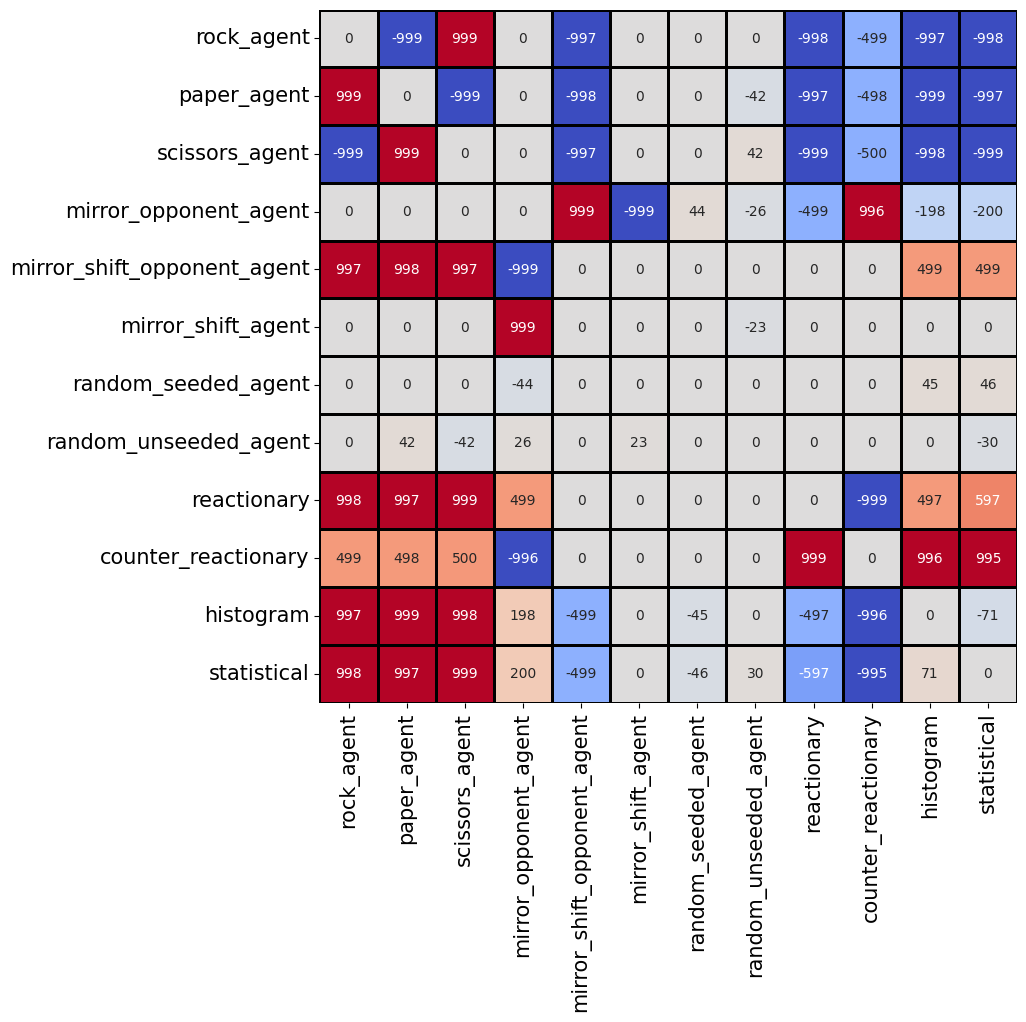

In [25]:
df_scores = pd.DataFrame(
    scores, 
    index=list_names, 
    columns=list_names,
)


plt.figure(figsize=(9, 9))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap='coolwarm', linewidths=1, 
    linecolor='black', fmt="d",
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);

# END